In [2]:
cd ..

/home/yann/IVISpaces


In [3]:
import numpy as np
import math
import torch
from torch import nn

from torch.distributions.multivariate_normal import MultivariateNormal


import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")
device

device(type='cuda', index=0)

In [5]:
def build_hydra(num_heads, num_outputs=1, direct_variance_head=False):
    class HydraHead(torch.nn.Module):
        def __init__(self, n_o):
            super(HydraHead, self).__init__()

            self.head_net = torch.nn.Sequential(
                     torch.nn.Linear(20, 20),
                     torch.nn.SELU(),
                     torch.nn.Linear(20, n_o))
            
        def forward(self, x):
            return self.head_net(x)
            
    class HydraNet(torch.nn.Module):
        def __init__(self, num_heads, num_outputs, direct_variance_head=False):
            super(HydraNet, self).__init__()
            self.shared_net = torch.nn.Sequential(
                torch.nn.Linear(1, 20),
                torch.nn.SELU(),
                torch.nn.Linear(20, 20),
                torch.nn.SELU()
            )
            #Initialize the heads
            self.num_heads = num_heads
            self.num_outputs = num_outputs
            self.heads = torch.nn.ModuleList([HydraHead(n_o=num_outputs) for h in range(num_heads)])

            if direct_variance_head:
                self.direct_variance_head = HydraHead(n_o=1)
            else:
                self.direct_variance_head = None
            
        def forward(self, x):
            y = self.shared_net(x)
            y_out = [head_net(y) for head_net in self.heads]

            #Append the direct variance to the end of the heads
            if self.direct_variance_head is not None:
                y_out.append(self.direct_variance_head(y))

            return torch.cat(y_out, 1)
            
    net = HydraNet(num_heads, num_outputs, direct_variance_head)
    return net


#NLL loss for single-headed NN
class GaussianLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianLoss, self).__init__()
    
    #Based on negative log of normal distribution
    def forward(self, input, target):
        mean = input[:, 0]
        sigma2 = torch.log(1. + torch.exp(input[:, 1])) + 1e-6
        #sigma2 = torch.nn.functional.softplus(input[:, 1]) + 1e-4
        loss = torch.mean(0.5*(mean - target.squeeze())*((mean - target.squeeze())/sigma2) + 0.5*torch.log(sigma2))
        return loss

#NLL loss for HydraNet
class GaussianHydraLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianHydraLoss, self).__init__()
    
    #Based on negative log of normal distribution
    def forward(self, input, target):

        mean = input[:, :-1]
        sigma2 = torch.log(1. + torch.exp(input[:, [-1]])) + 1e-6 #torch.abs(input[:, [-1]]) + 1e-6

        sigma2 = sigma2.repeat([1, mean.shape[1]])
        #sigma2 = torch.nn.functional.softplus(input[:, :, 1]) + 1e-4
        loss = 0.5*(mean - target)*((mean - target)/sigma2) + 0.5*torch.log(sigma2)
        return loss.mean()

In [6]:
def train_minibatch(model, loss, optimizer, x_val, y_val):

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)

    output = loss.forward(fx, y)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    return output.item() #fixed for new pytorch versionx

# Setup #

In [7]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


n_samples_FU=10 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


In [8]:
num_heads=10
num_epochs=5000
model = build_hydra(num_heads, num_outputs=1, direct_variance_head=True).to(device)
loss = GaussianHydraLoss()

#Necessary to have the same noise at every epoch
torch.manual_seed(42)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Duplicate the targets for each of the 'heads'
y_train_hydra =  y_train.squeeze(1).repeat(num_heads,1).t()
#y_train_hydra = y_train_hydra + target_noise_sigma*torch.randn_like(y_train_hydra)

N = x_train.shape[0]

with trange(num_epochs) as tr:
    for t in tr:    
        num_batches = N // batch_size
        cost = 0.
        count=0
        for (x,y) in train_loader:
            cost +=train_minibatch(model, loss, optimizer, x,y)
            count+=1
        tr.set_postfix(Cost=cost/count)



100%|██████████| 5000/5000 [03:35<00:00, 23.15it/s, Cost=-1.81]  


In [14]:
def test_hydranet_sigma(x_test, model):
    num_test_samples = x_test.shape[0]
    #Evaluate the model
    model.eval()
    y_t = model.forward(x_test).data.cpu().numpy()
    n = model.num_heads
    
    mu_i = y_t[:,:-1] # outputs from the n heads
    mu_star = np.mean(mu_i, axis=1) #The means of the n hydra head predictions
    
    sigma2_i = np.log(1. + np.exp(y_t[:,-1])) + 1e-6 #last head gives sigma2_i
    sigma2_hydra = np.var(mu_i, axis=1, ddof=1) #variance of hydranet outputs
    sigma2_star = sigma2_i + sigma2_hydra
    sigma_star = np.sqrt(sigma2_star) #variance of convolution of the two normal measures

    return (mu_star, sigma_star),np.sqrt(sigma2_hydra),np.sqrt(sigma2_hydra)

In [34]:
#compute metrics on test
from Metrics import LPP
results={}
log_device='cpu'
(mu_star, sigma_star), sigma_e, sigma_a= test_hydranet_sigma(x_test, model)
print(mu_star.shape)
y_pred=torch.as_tensor(mu_star).view(1,-1)+torch.as_tensor(sigma_e)*torch.randn(1000,mu_star.shape[0])
print(y_pred.shape)
metrics=evaluate_metrics(y_pred.unsqueeze(-1), torch.as_tensor(sigma_a).view(1,-1,1).cpu(), y_test.view(-1,1),  std_y_train, device='cpu', std=True)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})
mu=y_train.mean()
sigma=y_train.std()
y_pred=mu*torch.ones_like(y_test)
sigma_noise_train=sigma.view(1,1,1)
ref_LPP=LPP(y_pred.unsqueeze(0), y_test, sigma_noise_train.view(1,1,1), 'cpu')[0]
metrics.update({'SLPP':metrics['LPP'][0]-ref_LPP})
print(std_y_train)
print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

(600,)
torch.Size([1000, 600])


NameError: name 'execution_time' is not defined

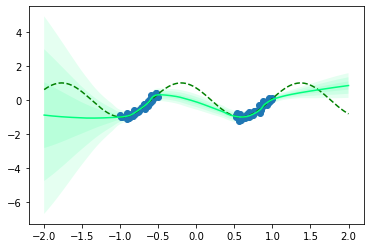

In [13]:
inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)

(mu_star, sigma_star)= test_hydranet_sigma(inputs, model)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')
plt.plot(inputs.cpu(), mu_star, color='springgreen')
for i in range(3):
    plt.fill_between(inputs.squeeze().cpu(), mu_star-(i+1)*sigma_star, mu_star+(i+1)*sigma_star, facecolor='springgreen', alpha=0.1)

plt.scatter(x_train.cpu(),y_train.cpu())

In [ ]:
plt.plot(inputs.cpu(),sigma2_hydra)

In [17]:
x_pred=torch.linspace(-2.,2.,1000).to(device)

log_sigma=model(x_pred,theta_log_sigma)
sigma_noise= torch.log(1. + log_sigma.exp()).detach() + 1e-6
print(sigma_noise.shape)
plt.plot(x_pred.cpu(),sigma_noise.cpu().squeeze())

NameError: name 'theta_log_sigma' is not defined

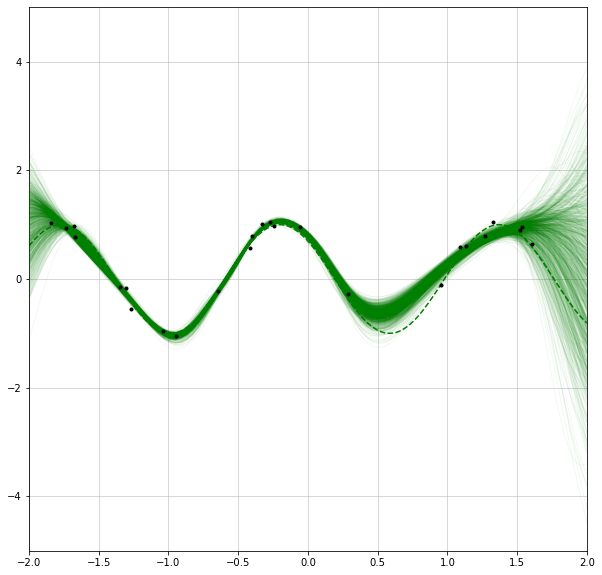

In [441]:
%matplotlib inline
fig=setup.makePlot(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

In [66]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, sigma_noise.cpu().view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong_sparse
RMSE: 0.29158592224121094
LPP: 0.2093910276889801
WAIC: -87.0604759156704
PICP: 0.8849999904632568
MPIW: 0.6802104711532593
time [s]: 58.76391024980694


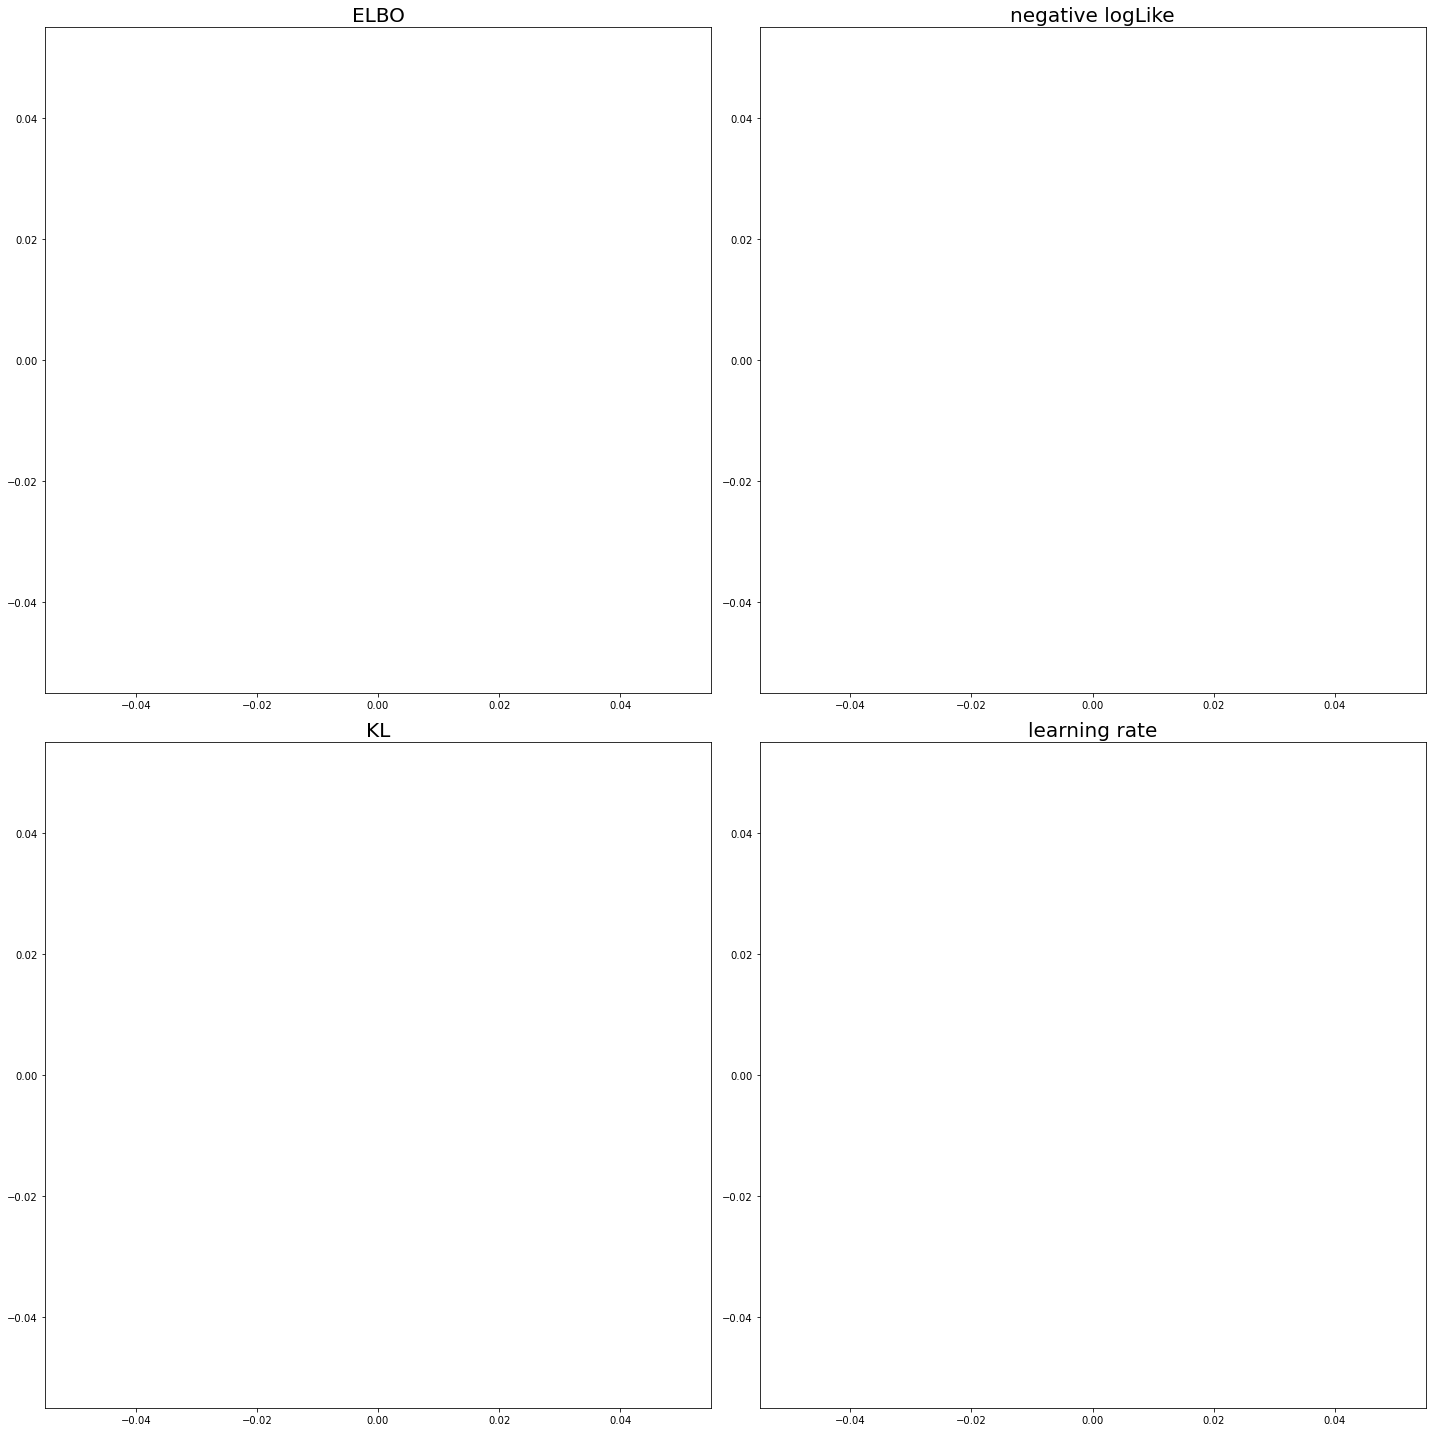

In [443]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

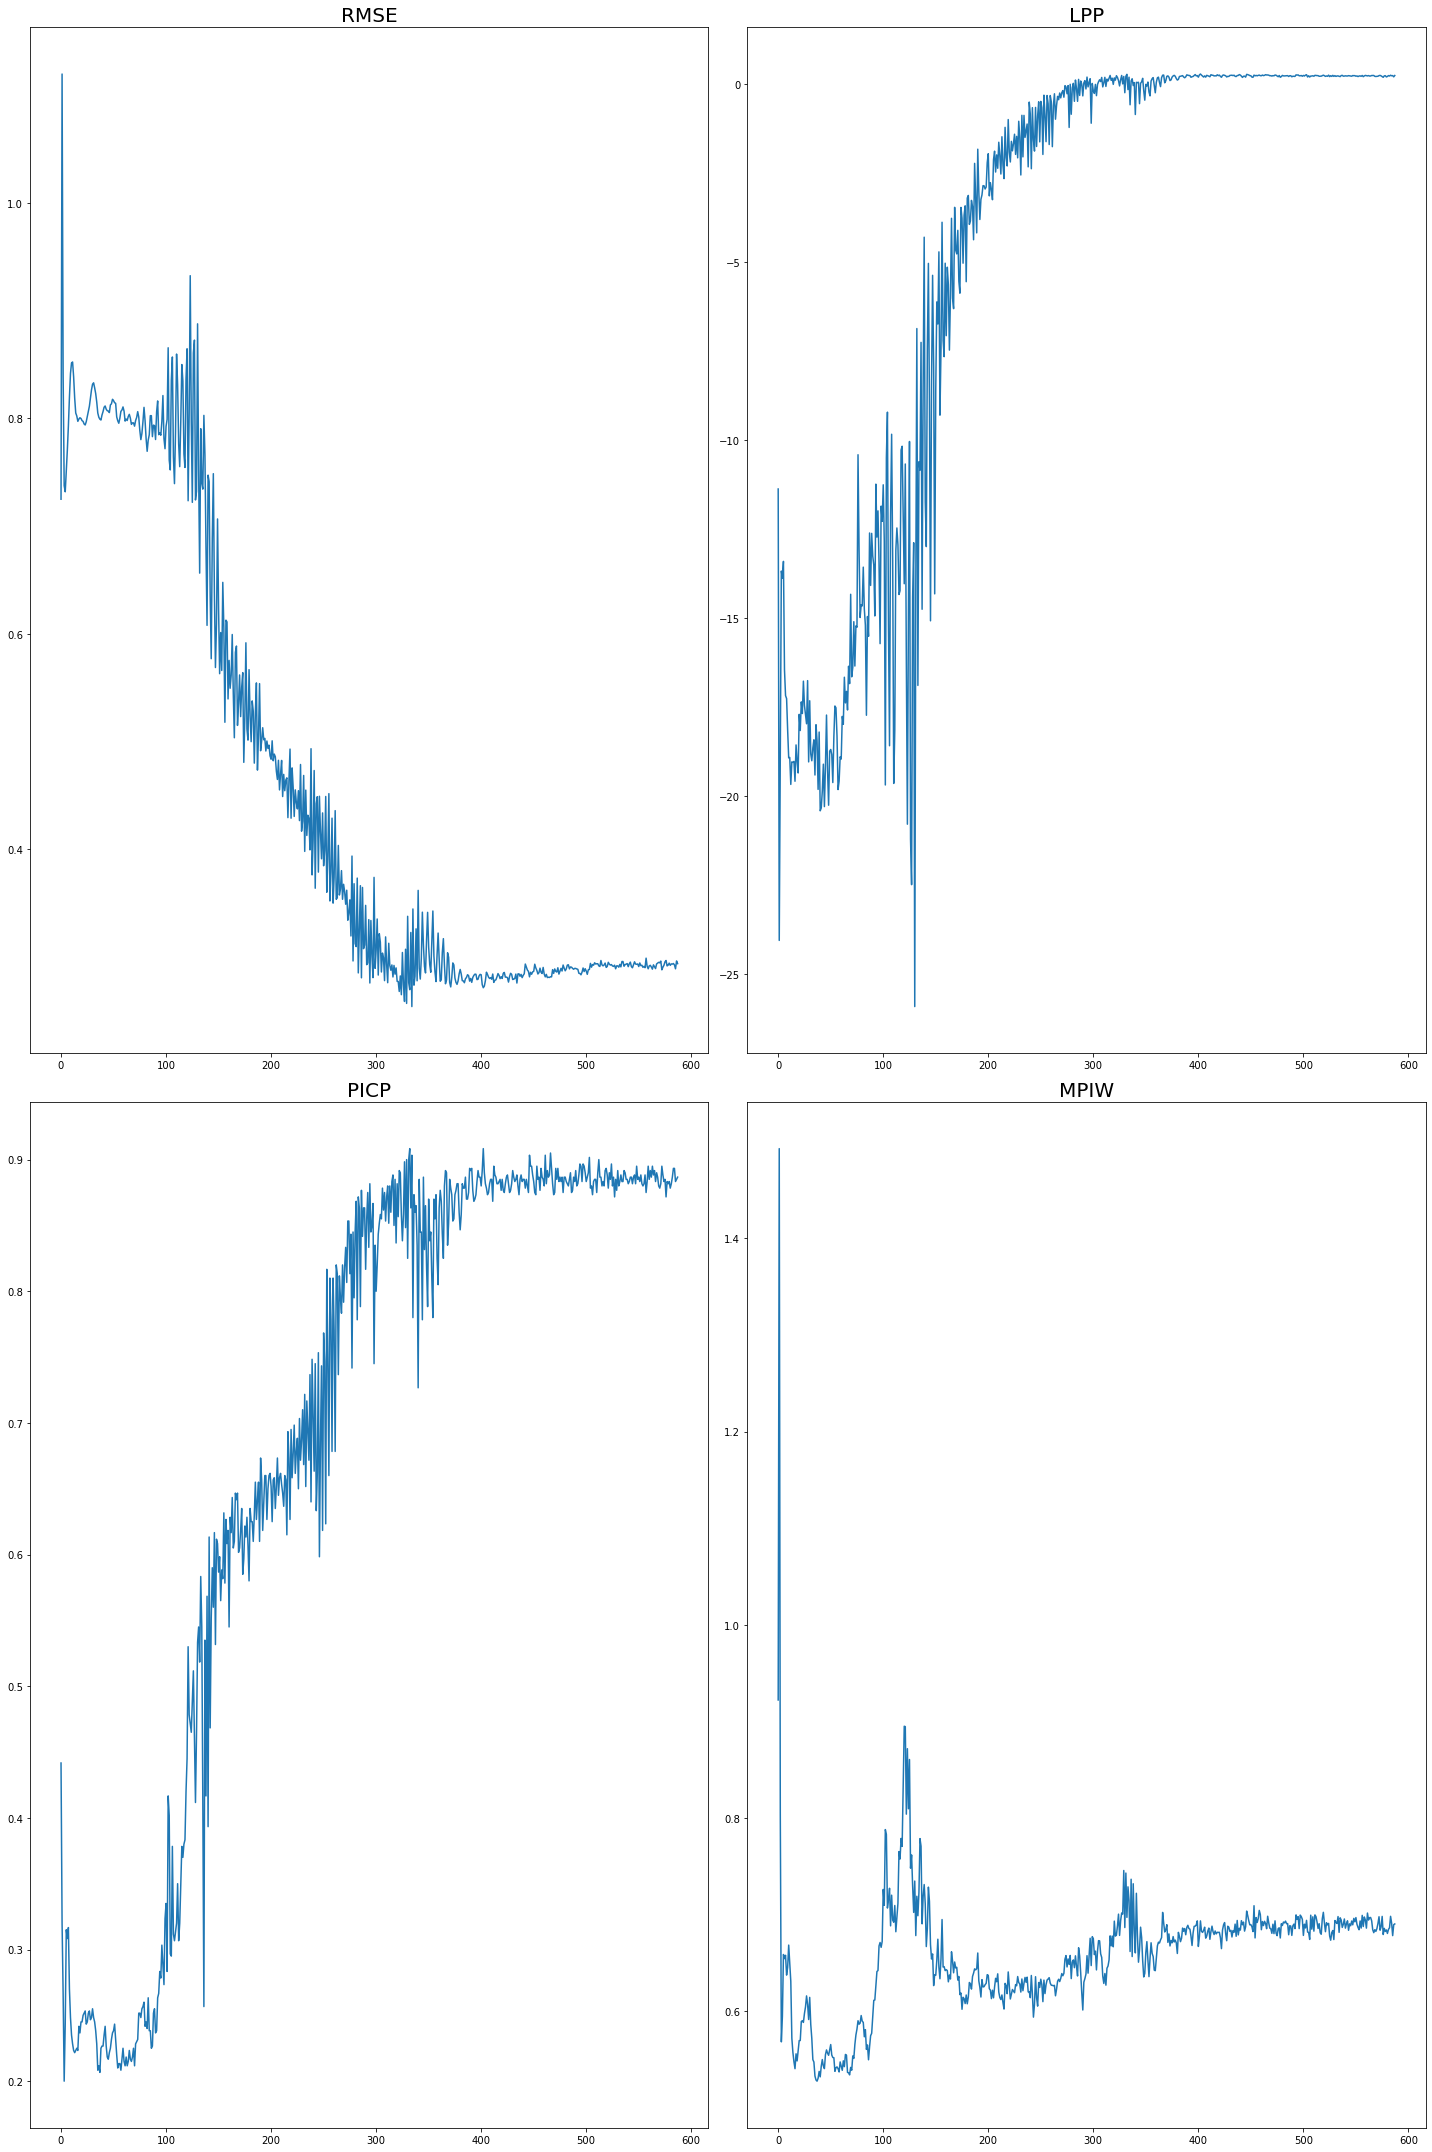

In [68]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
fig.tight_layout()

# Uncertainty vs error #

In [69]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)
X_total=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(1000)])).squeeze()
def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
y_total=f(X_total)
print(X_in.shape, y_in.shape)


torch.Size([200]) torch.Size([200, 1])


In [437]:
import seaborn as sns
X=[X_total]#[X_in,X_middle,X_out]
y=[y_total]#[y_in,y_middle,y_out]
label=['out of distribution']#['in distribution', 'in between', 'out of distribution']

def Entropy_(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x N X D
        k (Int): ordinal number

    Returns:
        (Tensor) H of size B, with H[b] k-Nearest Neighbour Estimation of the entropy of theta[b,:,:]

    """
    nb_samples=theta.shape[-2]
    dim=theta.shape[-1]
    kMC=torch.tensor(float(k_MC))
    D=torch.cdist(theta,theta)
    print(D.shape)
    a = torch.topk(D, k=k+1, dim=-1, largest=False, sorted=True)[0][:,:,-1]
    print('a: {}'.format(a.shape))
    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)#-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*a.div(torch.sqrt(kMC)).log().sum(-1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=GeN(1000).detach()
    pred_=model(X[i],theta.cpu())
    pred=pred_+sigma_noise.cpu()*torch.randn(pred_.shape[0],1,1)

    print(X[i].shape)
    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))

    print(pred.shape)
    H=(Entropy_(pred.transpose(0,1),k=20))
    print(H.shape)
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta.cpu())
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    print(MSE.shape)
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),MSE.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



RuntimeError: The size of tensor a (1000) must match the size of tensor b (500) at non-singleton dimension 1

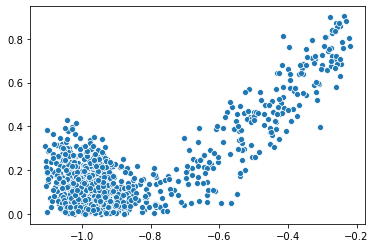

In [29]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())

In [29]:
#average log likelihood loss
from Tools import log_norm
def nll(x_data, y_data, theta):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """
    output=model(x_data,theta)
    y_pred=output[:-1,:,:]
    sigma_noise=torch.log(1. + torch.exp(output[-1,:,:])) + 1e-6
    log_proba=log_norm(y_data.unsqueeze(1), y_pred, sigma_noise.unsqueeze(0))
    return -log_proba.mean()

In [57]:
theta=torch.randn((11,param_count), device=device).requires_grad_(True)
#log_sigma=torch.tensor(0., device=device).requires_grad_(True)
params=[theta]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.1)
theta

tensor([[ 1.0427,  0.2547, -1.1250,  ...,  0.7009, -1.6748,  1.6438],
        [ 0.0326, -0.1381,  1.8362,  ...,  1.1169, -0.0921,  0.2630],
        [ 0.2847,  0.1339,  0.2234,  ..., -1.3767, -1.3539,  0.5811],
        ...,
        [ 1.2614, -0.6438, -0.1626,  ...,  0.7952, -0.9797, -1.3041],
        [ 0.1265, -1.4187,  0.8976,  ...,  1.0038, -0.5583, -0.4827],
        [ 1.1924,  0.8936, -0.1741,  ...,  0.2412,  0.4528,  2.2132]],
       device='cuda:0', requires_grad=True)

In [58]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]


n_epochs=10000


start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        optimizer.zero_grad()

        
        scores={'LL':0.
        }
        example_count=0.
        

        with torch.enable_grad():
            for (x,y) in train_loader:
                optimizer.zero_grad()

                L=nll(x,y,theta)
                
                                
                L.backward()
                
                optimizer.step()

                tr.set_postfix(NegLogLike=L.item())

                


100%|██████████| 10000/10000 [00:33<00:00, 298.81it/s, NegLogLike=-.676]  


In [48]:
print(theta.shape)

torch.Size([11, 151])


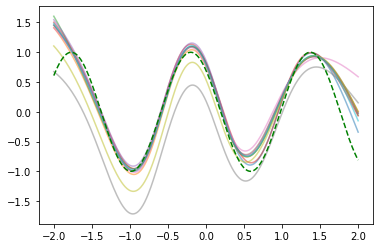

In [61]:


inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)
f=model(inputs,theta).squeeze().detach().cpu()

for i in range(10):
    plt.plot(inputs.cpu(),f[i,:],alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


torch.Size([500])
torch.Size([500])
torch.Size([500, 1])


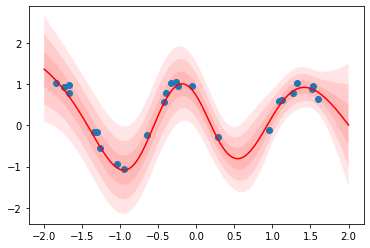

In [59]:
x_pred=inputs#torch.arange(-2.,2.,0.01).to(device)

output=model(x_pred,theta).detach()
f=output[:-1,:,:]
sigma_noise=sigma2 = torch.log(1. + torch.exp(output[-1,:])) + 1e-6
mean=f.mean(0).squeeze().cpu()
std=(f.std(0)+sigma_noise.detach()).squeeze().cpu()

print(std.shape)
print(mean.shape)
print(inputs.shape)


plt.plot(inputs.cpu(), mean, color='red')
for i in range(3):
    plt.fill_between(inputs.squeeze().cpu(), mean-(i+1)*std, mean+(i+1)*std, facecolor='red', alpha=0.1)
plt.scatter(x_train.cpu(),y_train.cpu())


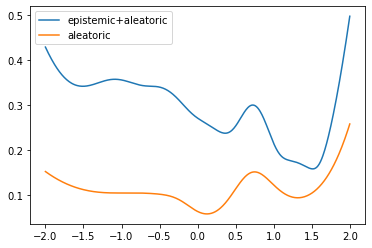

In [60]:
plt.plot(inputs.cpu(), std.cpu(), label='epistemic+aleatoric')
plt.plot(inputs.cpu(),sigma_noise.detach().cpu(),label='aleatoric')
plt.legend()